Todo:
- audio dataset automatic donload with code from kaggle
- make web scraping for text more flexible with names so it won't throw out an error whenever name doesnt match exactly
- do the eda with this rough data to see if it has everything we need for the pipline.
- create new file with buidling pipline so we won't have to rerun eda everytime.

# 1. Imports

## 1.1 Packages

In [10]:
import pandas as pd
import numpy as np
import requests
from selenium import webdriver
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
import librosa
import random
import time
import requests
from urllib.parse import unquote

## 1.2 Audio Dataset From kaggle.com

In [11]:
audio_path = "data/audio/original_dataset/"
audio_files = os.listdir(audio_path)
audio_df = pd.DataFrame({
    'model': [os.path.splitext(f)[0] for f in audio_files],
    'path': [os.path.join(audio_path, f) for f in audio_files]
})
print(audio_df.head())

                   model                                               path
0    38sws-dot38-caliber    data/audio/original_dataset/38sws-dot38-caliber
1                  ak-12                  data/audio/original_dataset/ak-12
2                  ak-47                  data/audio/original_dataset/ak-47
3  arctic-warfare-magnum  data/audio/original_dataset/arctic-warfare-magnum
4             beretta-92             data/audio/original_dataset/beretta-92


## 1.3 Image API From wikimedia.org

In [12]:
from image_api import ImageAPI
API_URL = "https://commons.wikimedia.org/w/api.php"
HEADERS = {"User-Agent": "Pipline/1.0 (mkakol.index@gmail.com)"}
audio_files = os.listdir(audio_path)
models = [os.path.splitext(f)[0] for f in audio_files]
image_df = ImageAPI(API_URL, HEADERS).fetch_images_for_models(models)

Searching for 38sws-dot38-caliber...
No image found for 38sws-dot38-caliber.
Searching for ak-12...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/c/c2/5%2C45mm_AK-12_6P70_assault_rifle_at_Military-technical_forum_ARMY-2016_03_noBG.png
Searching for ak-47...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/f/f6/AK-47_assault_rifle.jpg
Searching for arctic-warfare-magnum...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/0/0f/AWM-338-white.jpg
Searching for beretta-92...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/2/24/Beretta_92S_%28cropped%29.jpg
Searching for colt-1911...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/c/cf/Colt_M1911_Pistol_from_1912_Army_manual.png
Searching for daewoo-k2...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/5/59/Daewoo_K2_rifle_1.jpg
Searching for desert-eagle...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/8/81/2014-_Desert_Eagle_.50_Action_Express_Semi-Automatic_Pis

## 1.4 Web Scraping Text From gunsfandom.com (voorbeeld)

In [13]:
from text_webscraping import get_fandom_text
url = "https://guns.fandom.com/wiki/AK-47"
paras = get_fandom_text(url)
for i, p in enumerate(paras[:10]):
    print(p)

<p class="sitenotice-wrapper__title">Gun Wiki</p>
<p><font face="Verdana">
</font></p>
<p><font face="Verdana"><b><span style="font-size:160%; color:#FF0000;">M.O.S.</span> —</b> <span style="font-size:120%; color:#000;">Please read and keep the <b><a href="/wiki/Gun_Wiki:Manual_of_Style" title="Gun Wiki:Manual of Style">Manual of Style</a></b> in mind while editing.</span>
</font></p>
<p><font face="Verdana"><b><span style="font-size:120%; color:#FF0000;">Also, remember that there is to be no copying and pasting from other sources, at any time - your edits must be in your OWN words!</span></b>
</font></p>
<p>READ MORE</p>
<p>
<aside class="portable-infobox pi-background pi-border-color pi-theme-wikia pi-layout-default" role="region">
<div class="pi-image-collection wds-tabber" data-source="image">
<div class="wds-tabs__wrapper">
<ul class="wds-tabs">
<li class="wds-tabs__tab wds-is-current">
<span class="wds-tabs__tab-label">
							AK-47
							
						</span>
</li>
<li class="wds-tab

# 2. EDA

## 2.1 Audio EDA

We nemen de audio dataset als basis, omdat dit als enige meteen als gestructureerde database komt. Elke subfolder is genoemd naar een firearm, wat wij gebruiken als identifier om data te vinden via API of web scraping. Dit is handig omdat we de namen niet handmatig hoeven in te vullen en het vormt een natuurlijke guide voor onze pipeline.

Het audio dataset bevat in totaal 1450 bestanden, verspreid over 58 unieke firearmen. Dit betekent dat voor elke firearm er 25 verschillende audio bestanden beschikbaar zijn, wat ons helpt beter inzicht te krijgen in de variatie van geluiden per wapen. Het doel is om op basis van deze data de feature avg_shots_per_sec te berekenen en te kijken of er correlatie is met de target weapon_type (pistol, rifle, shotgun).

Elke audio sample is 0.5 seconden lang, met een sample rate van 22050 Hz, en de bestandsgrootte is uniform van 43 KB). De dataset is vrij schoon en gestandaardiseerd, waardoor veel preprocessing niet nodig is.

Voor feature engineering trekken we metadata uit de audios: het aantal peaks per sample om avg_shots_per_sec te berekenen en de amplitude van de peaks voor een indicatie van avg_loudness. Signalen bevatten veel ruis, maar meestal overheerst één duidelijke frequentie, waardoor een uitgebreide Fourier-analyse niet nodig is. Gemeten min en peak frequencies liggen tussen 2 en 3844 Hz, wat bruikbaar is voor zowel het tellen van schoten als het beoordelen van het volume.

Audio files: 1450
Unique firearms: 58
Audios per firearm: {'38sws-dot38-caliber': 25, 'ak-12': 25, 'ak-47': 25, 'arctic-warfare-magnum': 25, 'beretta-92': 25, 'colt-1911': 25, 'daewoo-k2': 25, 'desert-eagle': 25, 'double-barrel-shotgun': 25, 'dp-27-lmg': 25, 'fn-p90': 25, 'fn-scar': 25, 'glock': 25, 'glock-18c': 25, 'glock-19-9mm-luger-pistol': 25, 'high-standard-22lr': 25, 'hk-g36c': 25, 'hk-ump45': 25, 'hk-usp-compact-40-sw-pistol': 25, 'kar98k': 25, 'kimber-45acp': 25, 'kriss-vector': 25, 'lorcin-380acp': 25, 'm16': 25, 'm24-sws': 25, 'm249-lmg': 25, 'm4': 25, 'mg42-lmg': 25, 'mini-14': 25, 'mk14-ebr': 25, 'mp-40-40-sw-pistol': 25, 'mp5-smg': 25, 'nagant-m1895': 25, 'ots-14-groza': 25, 'pp-19-bizon': 25, 'pump-action-shotgun': 25, 'qbu-88': 25, 'qbz-95': 25, 'remington-22lr': 25, 'remington-700': 25, 'remington-870': 25, 'rhino-60ds': 25, 'ruger-22lr': 25, 'ruger-357': 25, 'ruger-ar-556': 25, 'saiga-12k': 25, 'sig-p225': 25, 'sks-rifle': 25, 'slr-rifle': 25, 'steyr-aug': 25, 'sw-10-

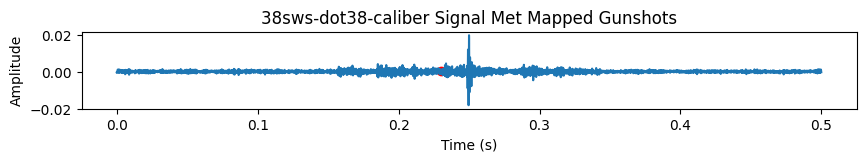

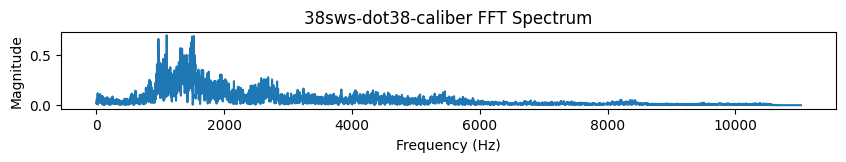

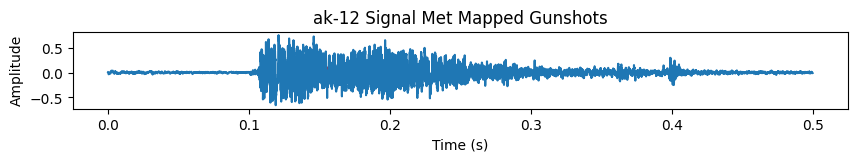

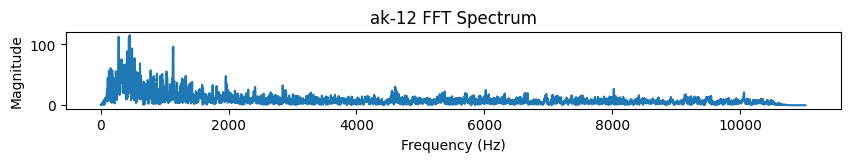

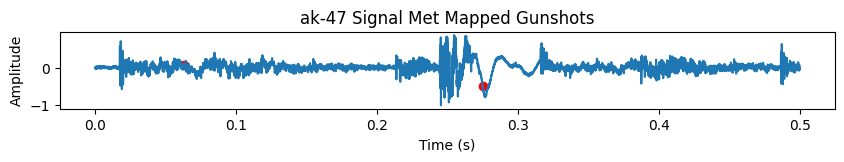

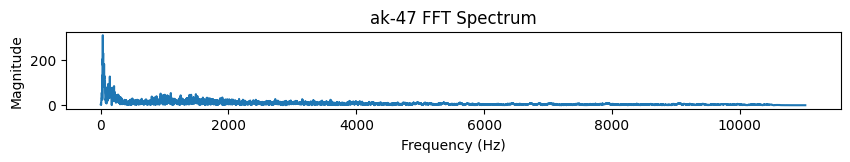

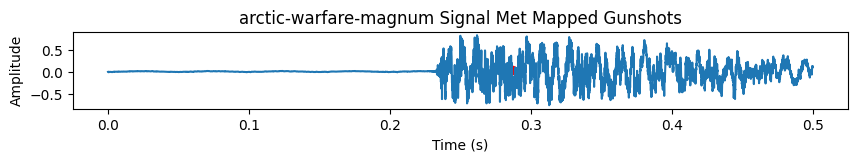

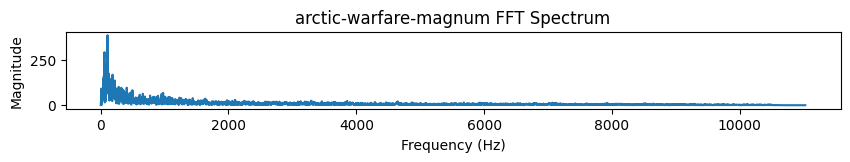

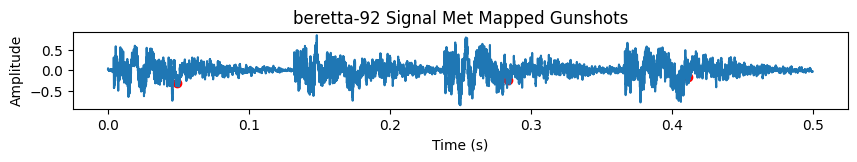

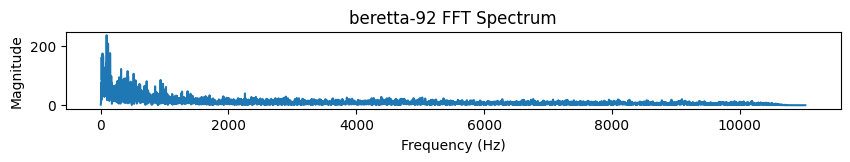

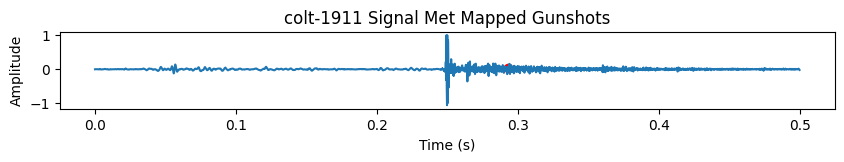

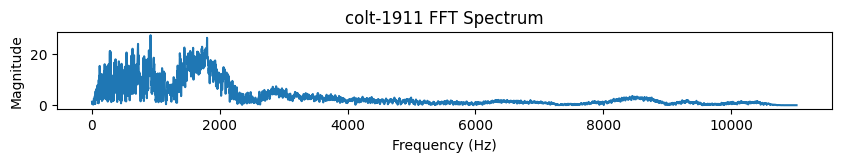

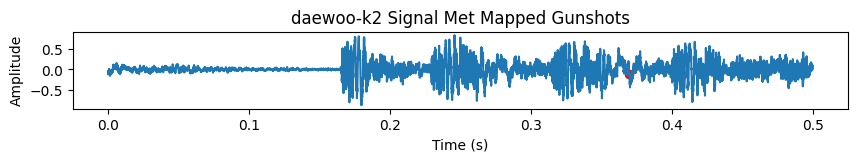

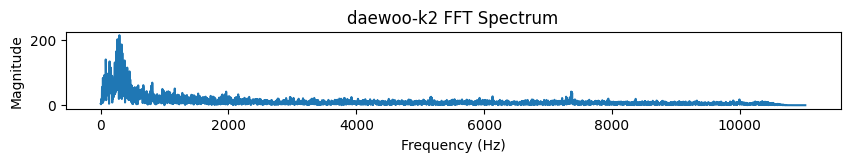

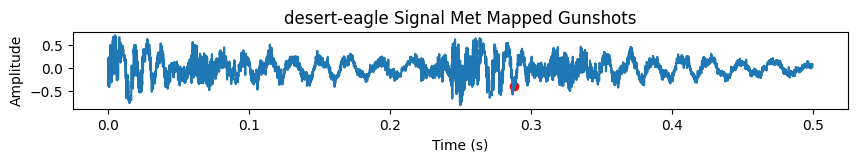

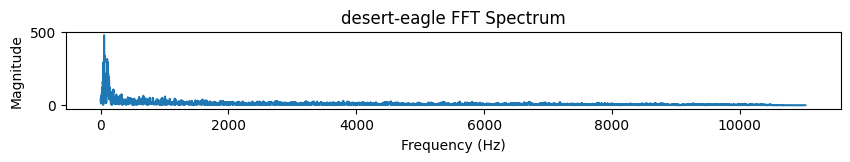

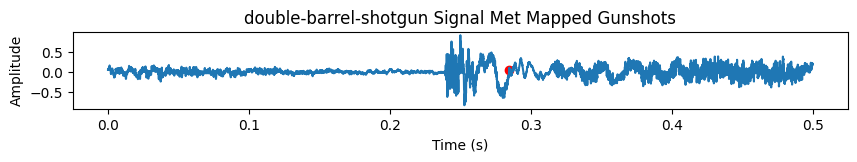

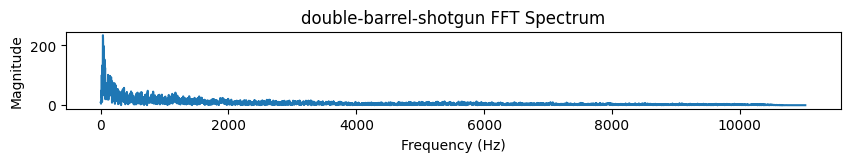

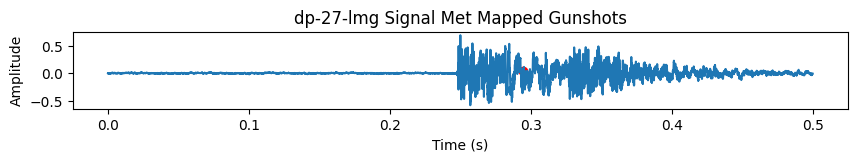

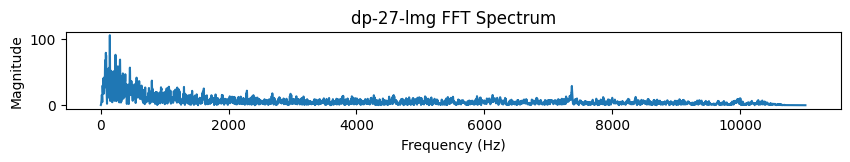

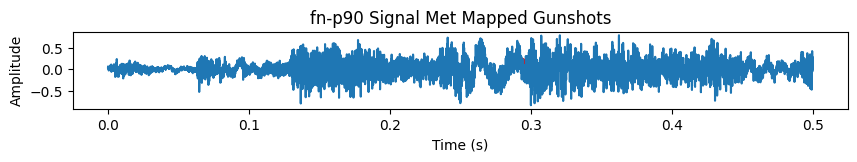

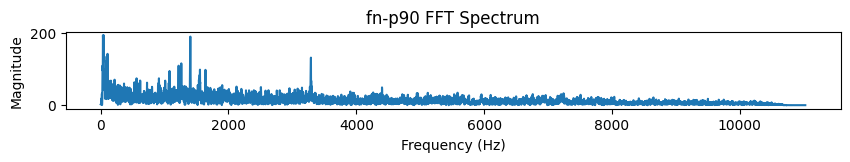

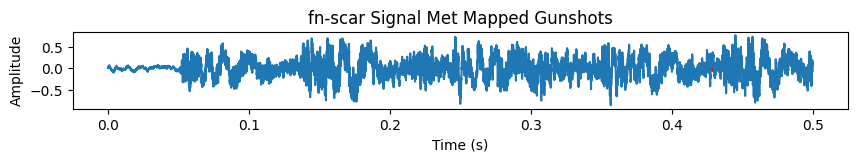

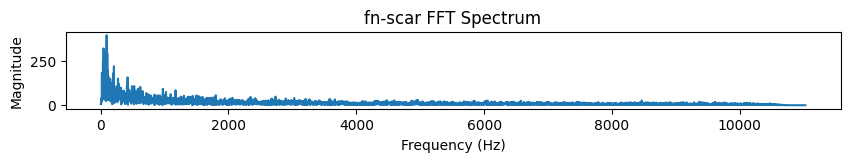

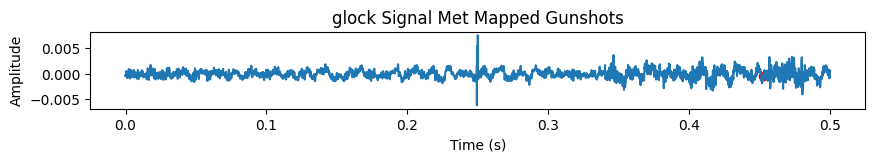

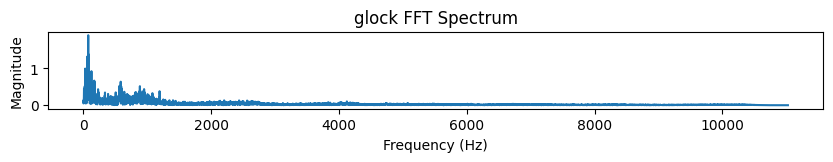

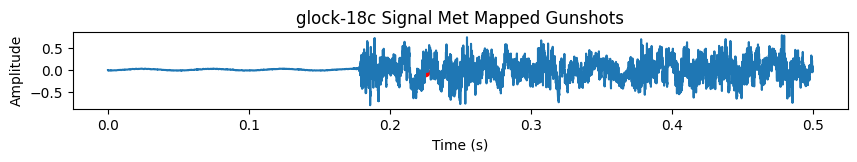

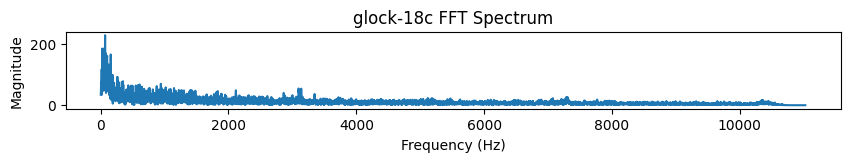

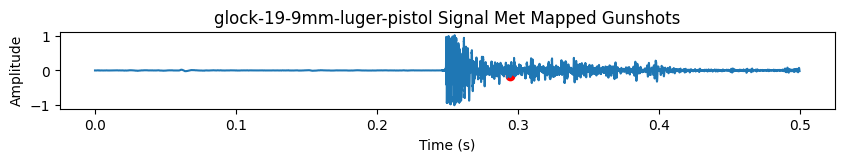

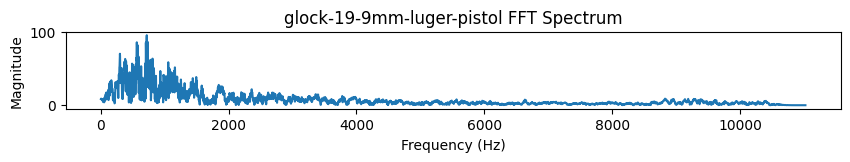

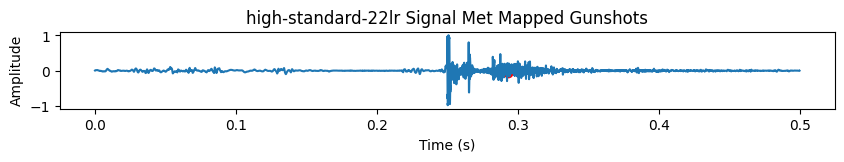

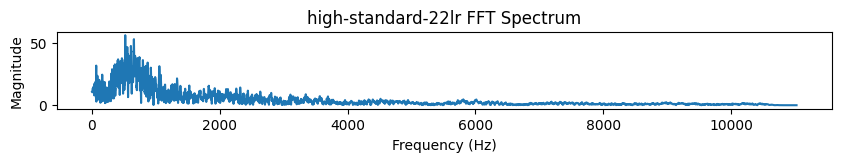

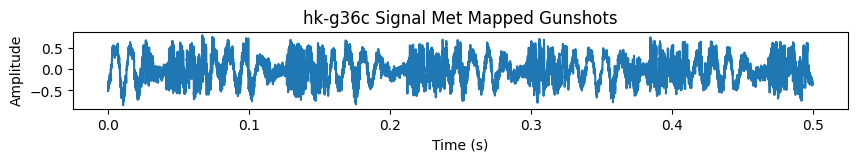

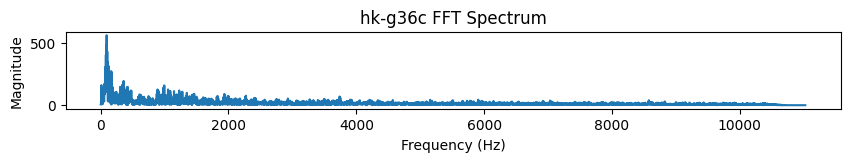

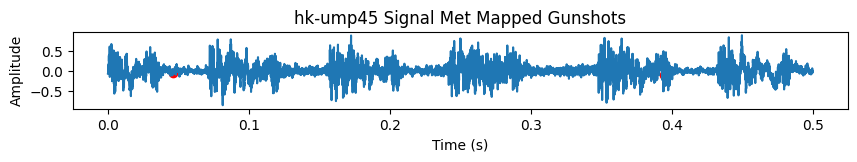

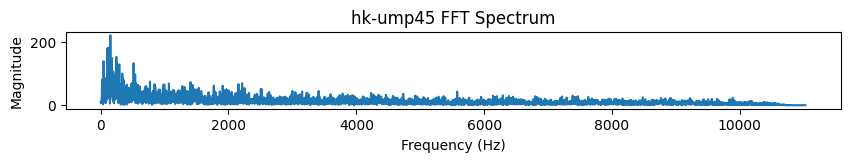

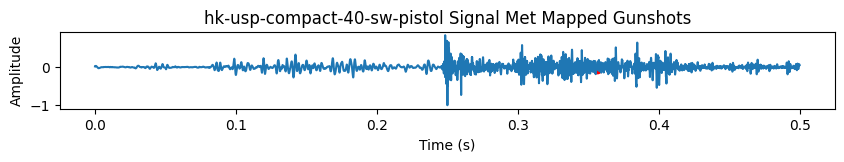

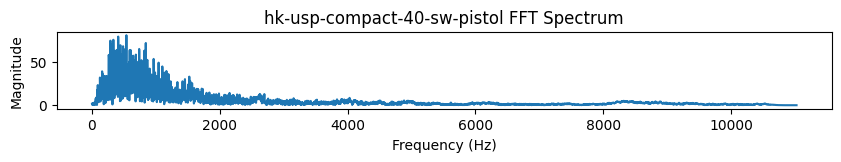

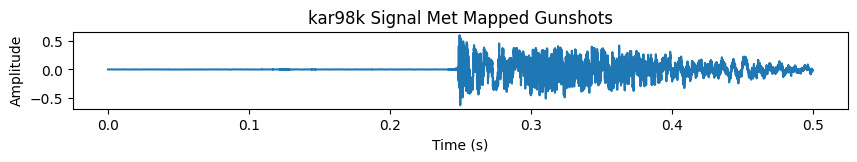

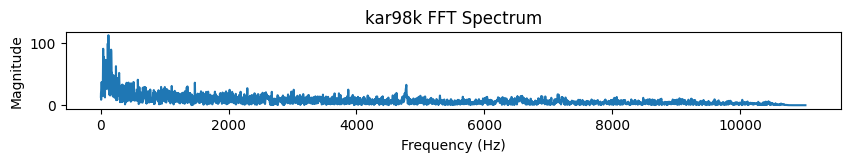

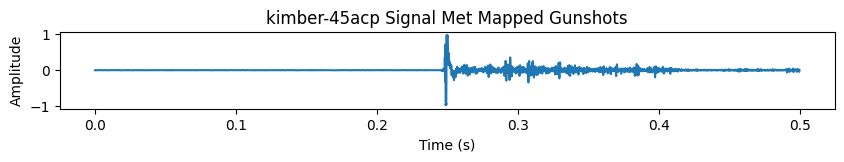

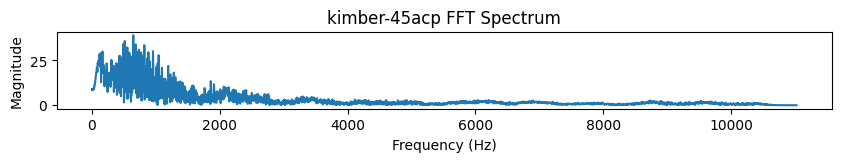

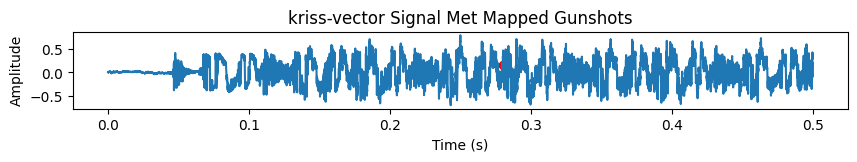

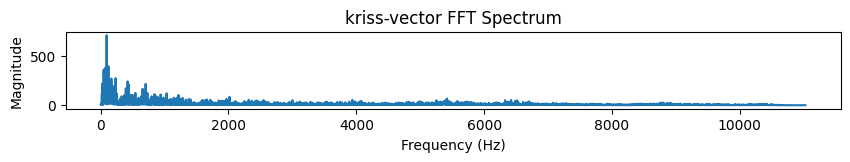

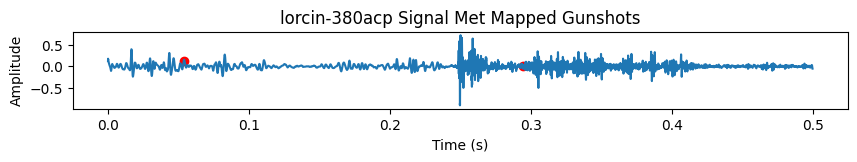

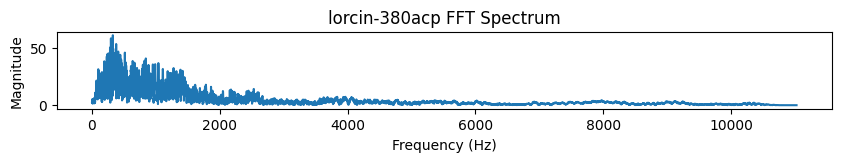

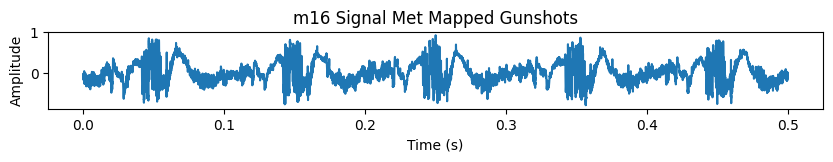

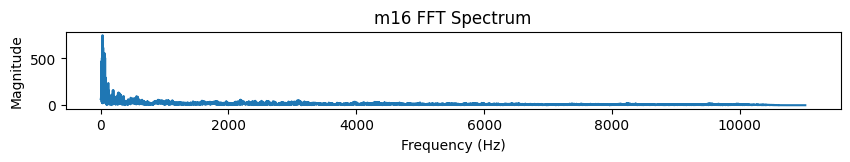

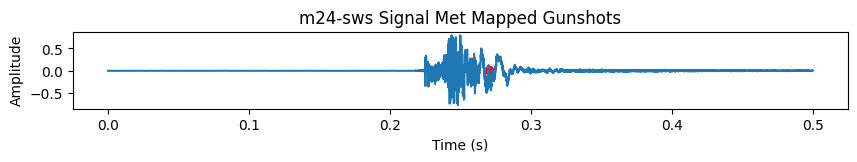

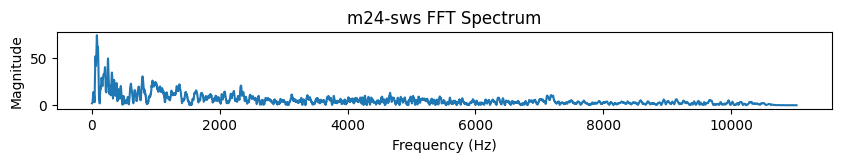

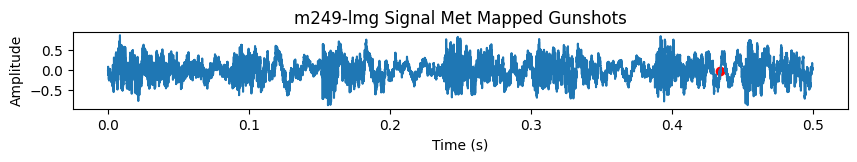

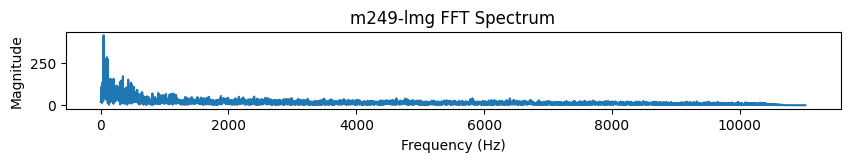

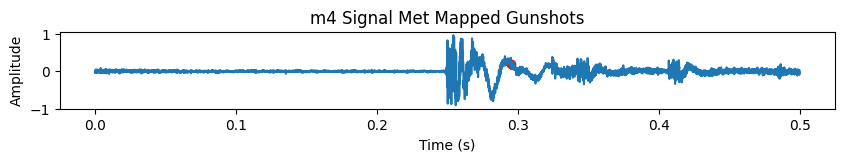

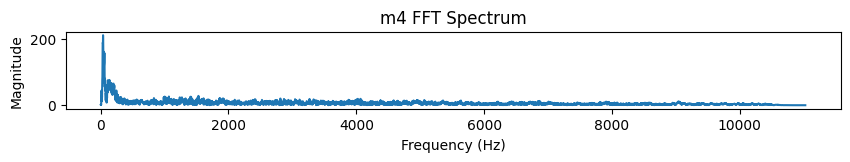

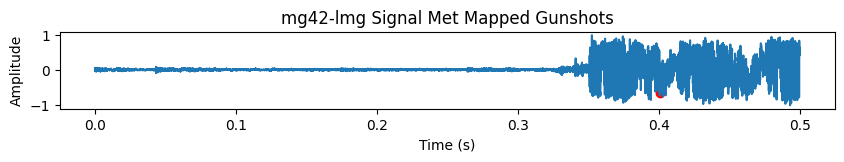

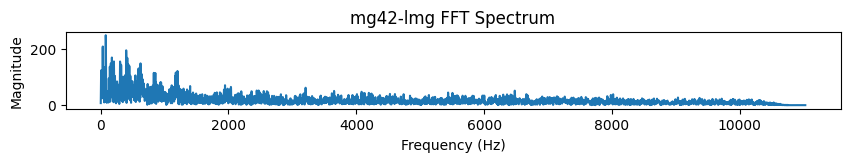

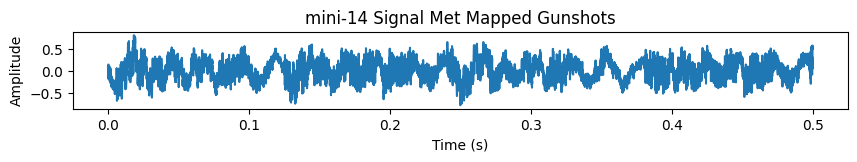

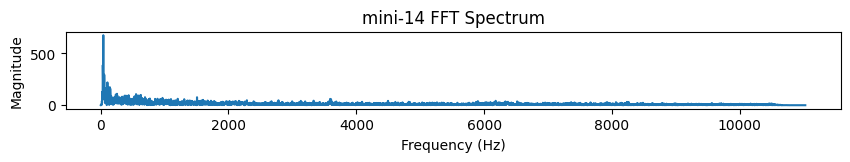

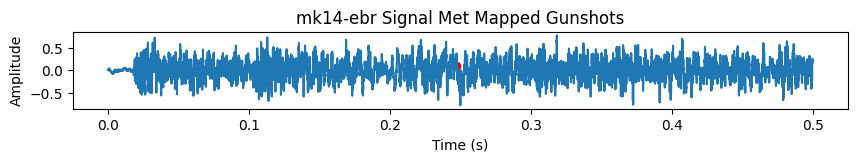

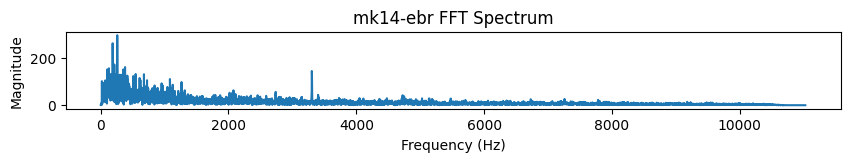

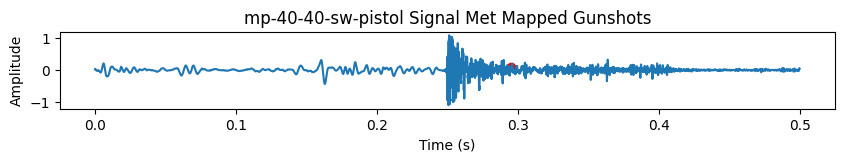

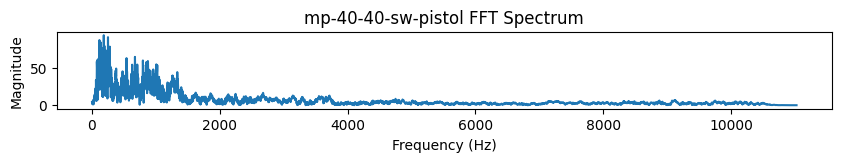

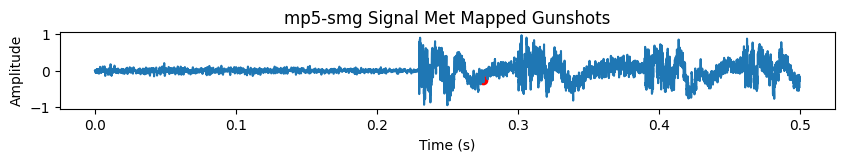

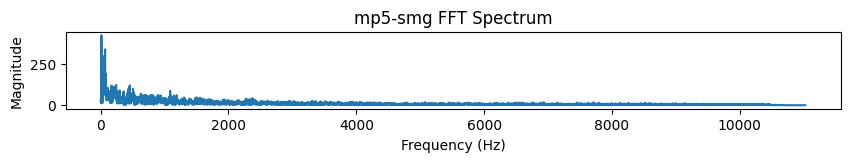

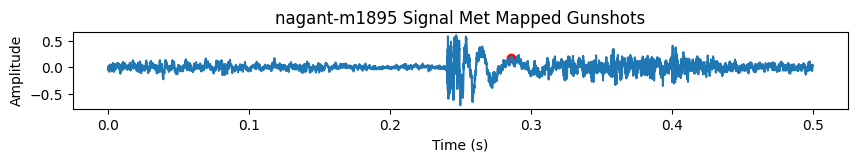

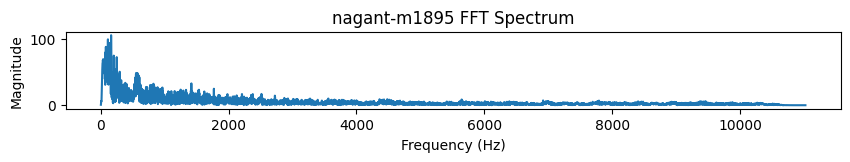

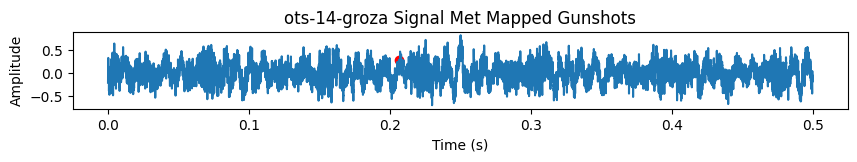

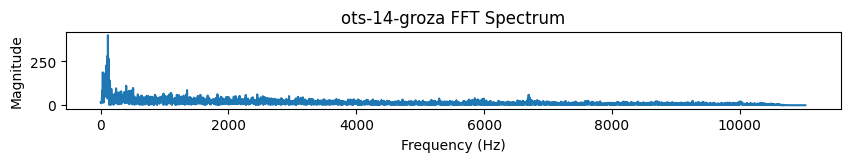

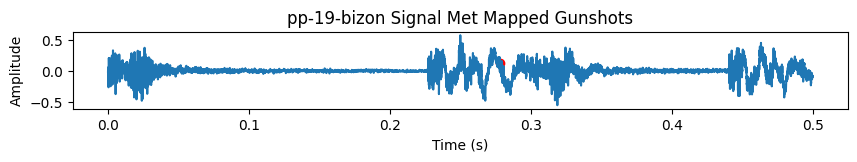

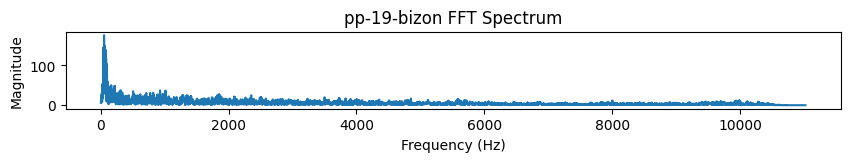

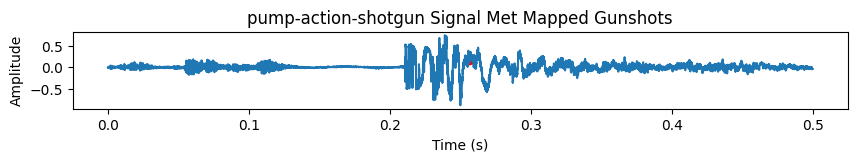

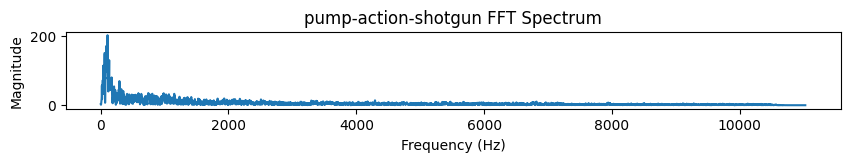

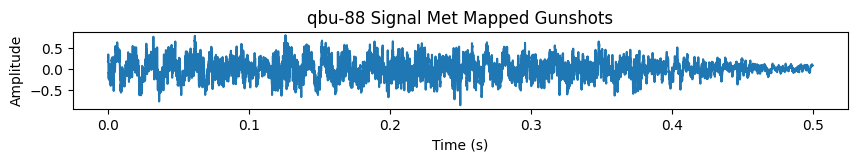

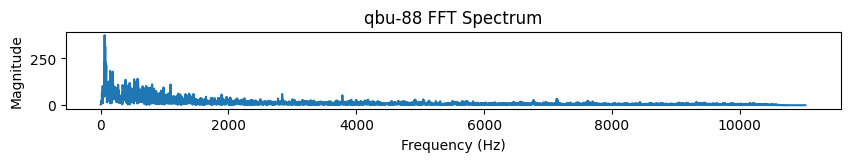

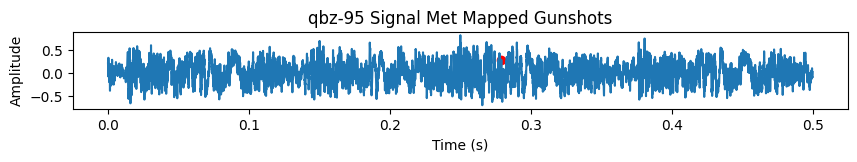

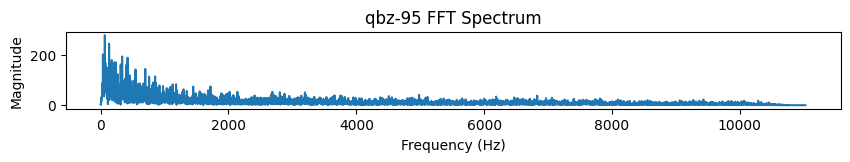

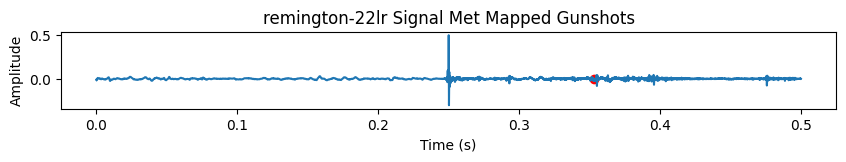

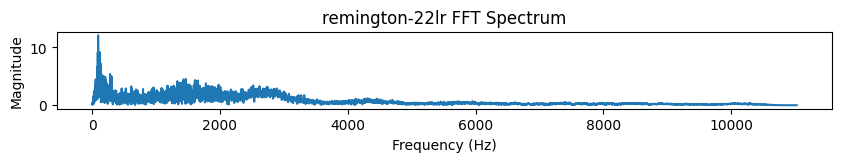

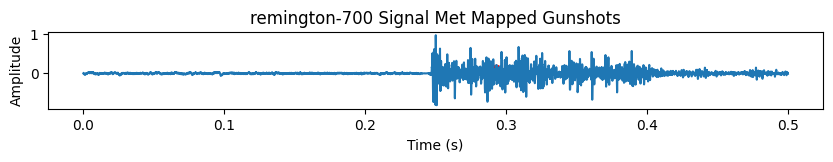

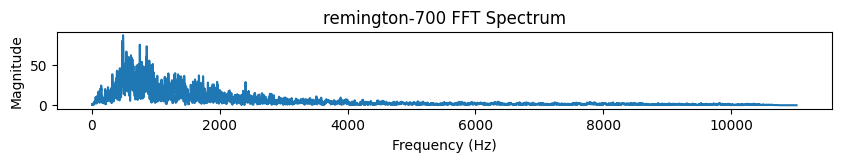

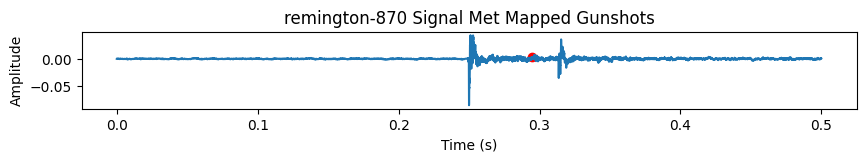

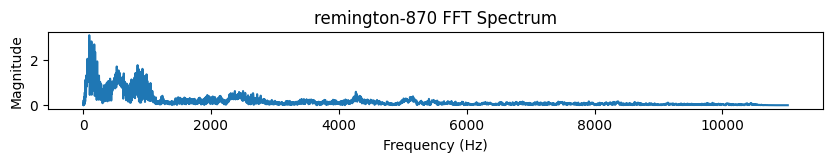

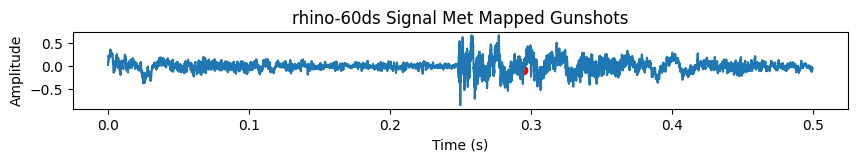

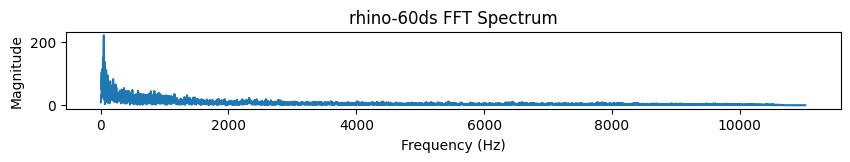

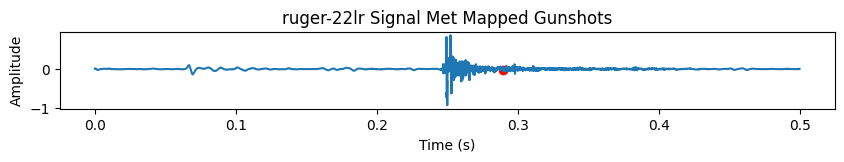

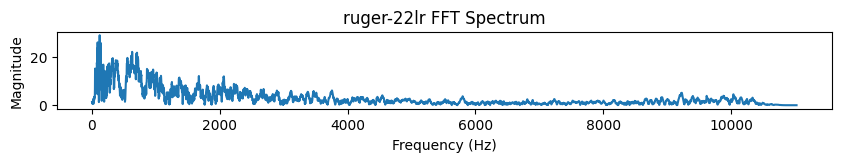

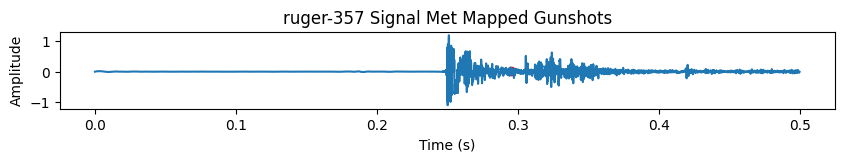

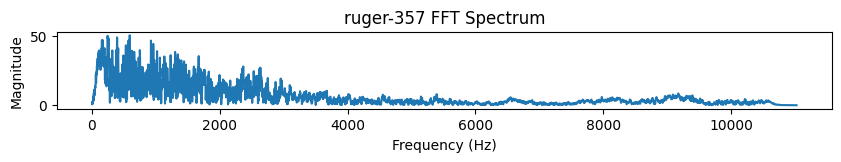

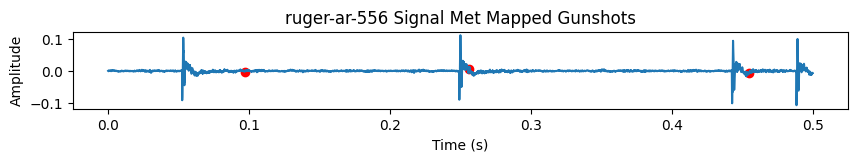

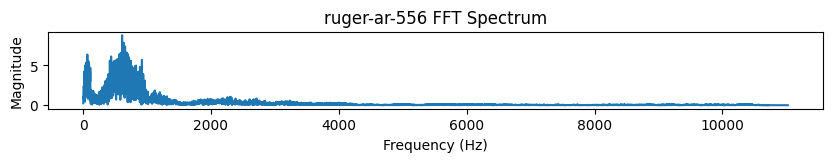

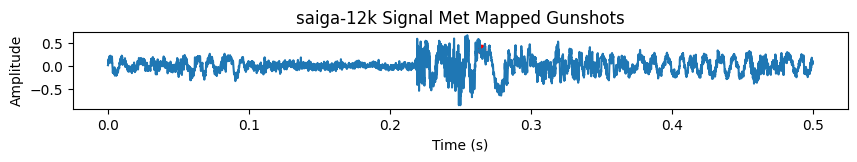

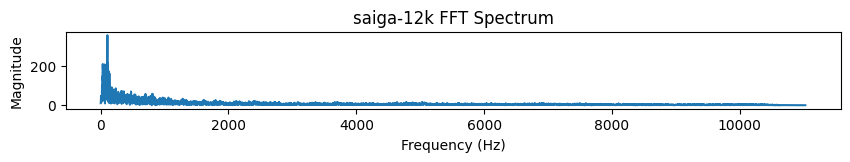

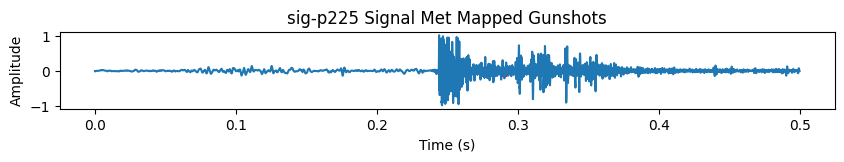

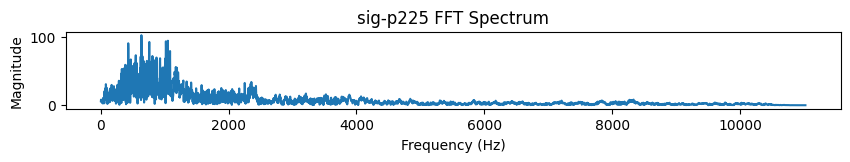

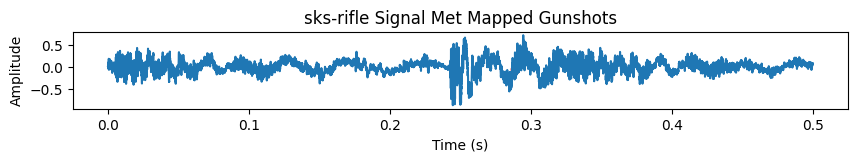

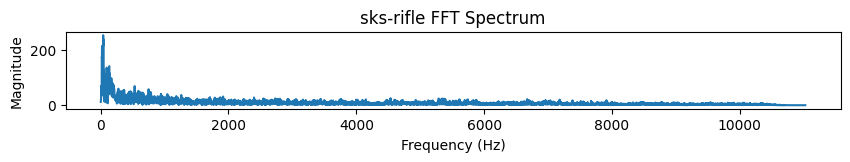

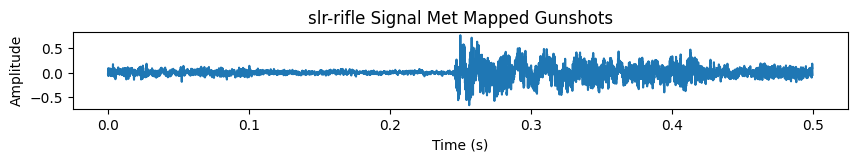

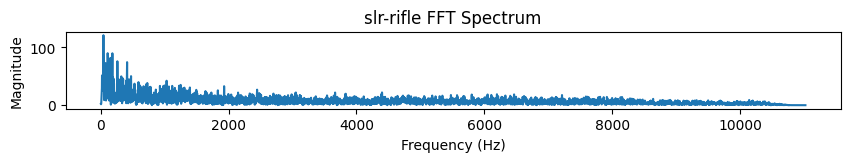

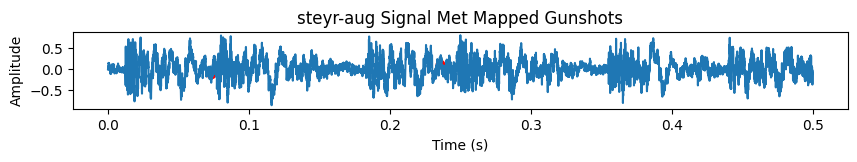

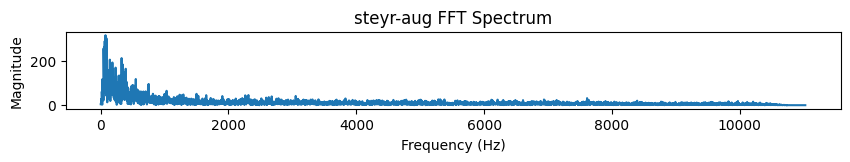

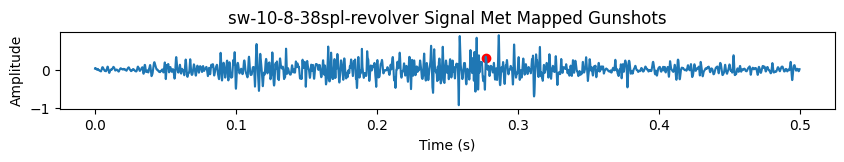

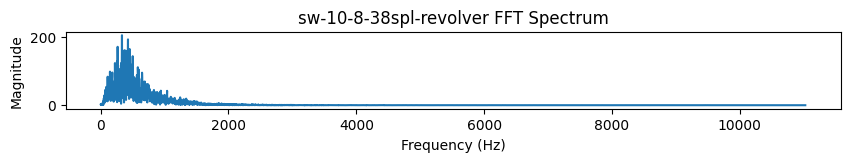

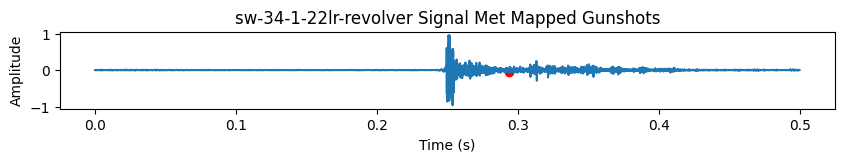

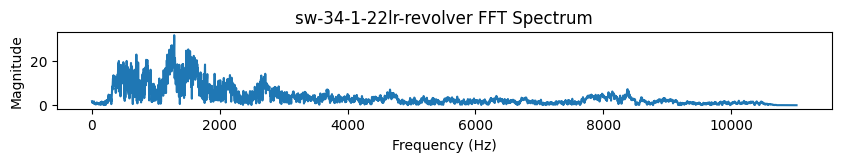

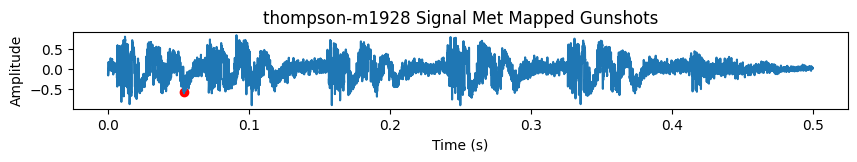

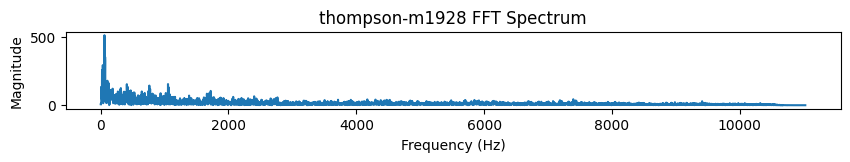

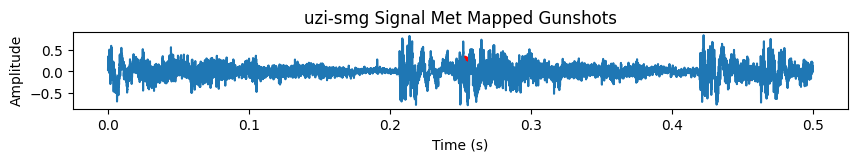

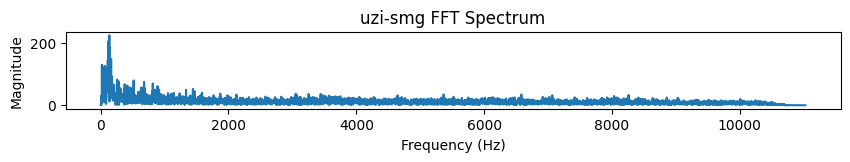

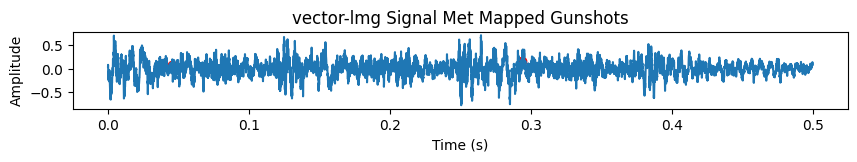

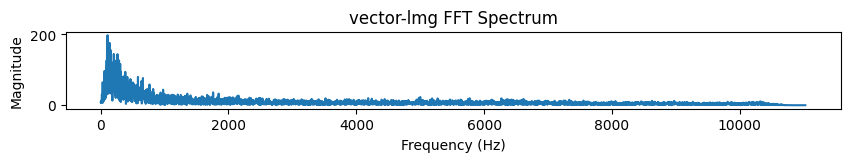

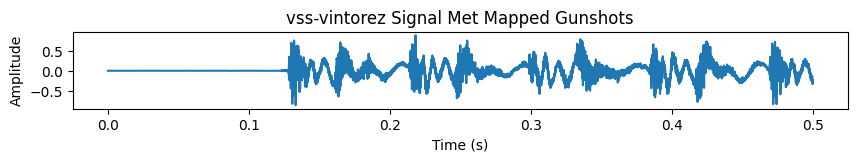

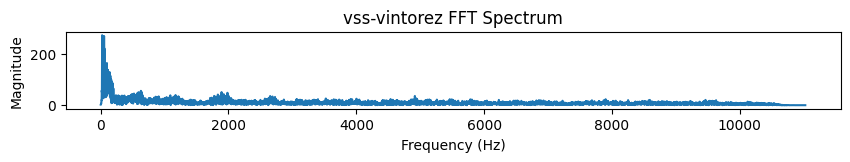

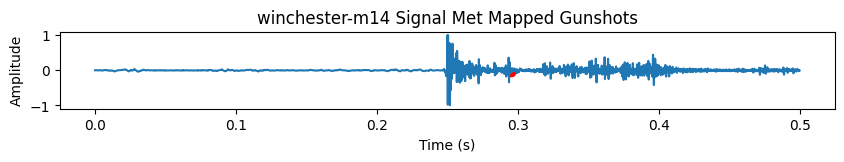

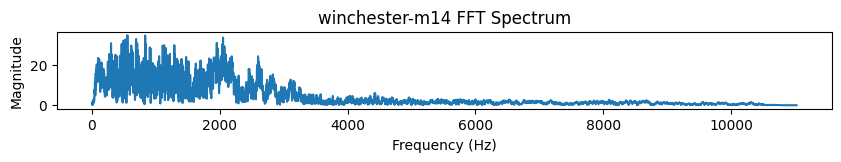

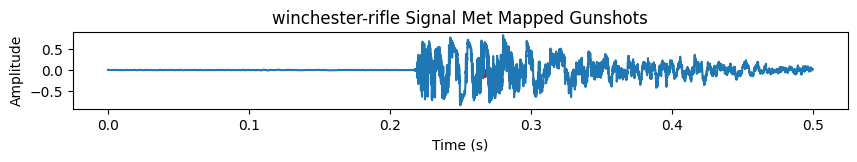

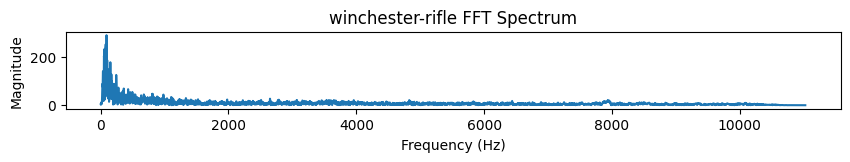

               firearm                                           filename  \
0  38sws-dot38-caliber  38sws-dot38-caliber_001_4a48b77c-72bf-4917-b8b...   
1  38sws-dot38-caliber  38sws-dot38-caliber_002_3ab0f1bb-f7fe-4cfe-a78...   
2  38sws-dot38-caliber  38sws-dot38-caliber_003_090f69a9-885c-45fb-a80...   
3  38sws-dot38-caliber  38sws-dot38-caliber_004_907b513b-dd5e-4756-a20...   
4  38sws-dot38-caliber  38sws-dot38-caliber_005_a7973dd2-b255-4711-9f9...   

                                                path  
0  data/audio/original_dataset\38sws-dot38-calibe...  
1  data/audio/original_dataset\38sws-dot38-calibe...  
2  data/audio/original_dataset\38sws-dot38-calibe...  
3  data/audio/original_dataset\38sws-dot38-calibe...  
4  data/audio/original_dataset\38sws-dot38-calibe...  


In [14]:
from audio_dataset import audio_eda
audio_df, counts, dur, srates, peak_freqs = audio_eda("data/audio/original_dataset")
print(audio_df.head())

## 2.2 Image EDA

Inladen van de metadata

In [15]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os

img_df = pd.read_csv("data/images/image_metadata.csv")
img_df.head()


,model,url,path
0,ak-12,https://upload.wikimedia.org/wikipedia/commons...,data/images\ak-12.jpg
1,ak-47,https://upload.wikimedia.org/wikipedia/commons...,data/images\ak-47.jpg
2,arctic-warfare-magnum,https://upload.wikimedia.org/wikipedia/commons...,data/images\arctic-warfare-magnum.jpg
3,beretta-92,https://upload.wikimedia.org/wikipedia/commons...,data/images\beretta-92.jpg
4,colt-1911,https://upload.wikimedia.org/wikipedia/commons...,data/images\colt-1911.jpg


Controleer of alle beelden goed zijn gedownload

In [16]:
img_df["exists"] = img_df["path"].apply(lambda p: os.path.exists(p))
img_df


,model,url,path,exists
0,ak-12,https://upload.wikimedia.org/wikipedia/commons...,data/images\ak-12.jpg,True
1,ak-47,https://upload.wikimedia.org/wikipedia/commons...,data/images\ak-47.jpg,True
2,arctic-warfare-magnum,https://upload.wikimedia.org/wikipedia/commons...,data/images\arctic-warfare-magnum.jpg,True
3,beretta-92,https://upload.wikimedia.org/wikipedia/commons...,data/images\beretta-92.jpg,True
4,colt-1911,https://upload.wikimedia.org/wikipedia/commons...,data/images\colt-1911.jpg,True
5,daewoo-k2,https://upload.wikimedia.org/wikipedia/commons...,data/images\daewoo-k2.jpg,True
6,desert-eagle,https://upload.wikimedia.org/wikipedia/commons...,data/images\desert-eagle.jpg,True
7,double-barrel-shotgun,https://upload.wikimedia.org/wikipedia/commons...,data/images\double-barrel-shotgun.jpg,True
8,dp-27-lmg,https://upload.wikimedia.org/wikipedia/commons...,data/images\dp-27-lmg.jpg,True
9,fn-p90,https://upload.wikimedia.org/wikipedia/commons...,data/images\fn-p90.jpg,True


Basis EDA: Afmetingen & bestandsgrootte

In [17]:
def get_img_stats(path):
    try:
        img = Image.open(path)
        width, height = img.size
        mode = img.mode
        file_size = os.path.getsize(path)
        return width, height, mode, file_size
    except:
        return None, None, None, None

img_df[["width", "height", "mode", "filesize"]] = img_df["path"].apply(
    lambda p: pd.Series(get_img_stats(p))
)

img_df


,model,url,path,exists,width,height,mode,filesize
0,ak-12,https://upload.wikimedia.org/wikipedia/commons...,data/images\ak-12.jpg,True,2543.0,1248.0,RGBA,1237086.0
1,ak-47,https://upload.wikimedia.org/wikipedia/commons...,data/images\ak-47.jpg,True,900.0,332.0,RGB,72464.0
2,arctic-warfare-magnum,https://upload.wikimedia.org/wikipedia/commons...,data/images\arctic-warfare-magnum.jpg,True,1998.0,810.0,RGB,305191.0
3,beretta-92,https://upload.wikimedia.org/wikipedia/commons...,data/images\beretta-92.jpg,True,2130.0,1377.0,RGB,356971.0
4,colt-1911,https://upload.wikimedia.org/wikipedia/commons...,data/images\colt-1911.jpg,True,2220.0,1488.0,L,1545577.0
5,daewoo-k2,https://upload.wikimedia.org/wikipedia/commons...,data/images\daewoo-k2.jpg,True,2000.0,654.0,RGB,197613.0
6,desert-eagle,https://upload.wikimedia.org/wikipedia/commons...,data/images\desert-eagle.jpg,True,1777.0,1185.0,RGB,682860.0
7,double-barrel-shotgun,https://upload.wikimedia.org/wikipedia/commons...,data/images\double-barrel-shotgun.jpg,True,4624.0,2136.0,RGB,2927330.0
8,dp-27-lmg,https://upload.wikimedia.org/wikipedia/commons...,data/images\dp-27-lmg.jpg,True,8448.0,5718.0,RGB,23841530.0
9,fn-p90,https://upload.wikimedia.org/wikipedia/commons...,data/images\fn-p90.jpg,True,3072.0,1728.0,RGB,477671.0


Visualiseer sample-afbeeldingen

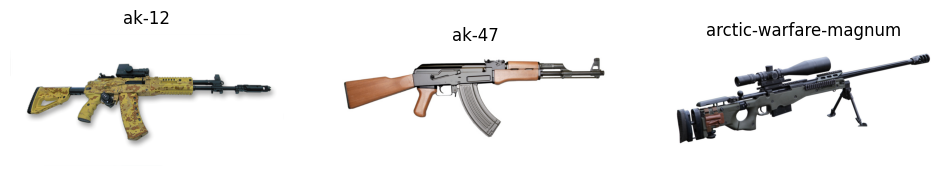

In [18]:
plt.figure(figsize=(12, 6))
for idx, row in img_df.head(3).iterrows():
    img = Image.open(row["path"])
    plt.subplot(1, 3, idx+1)
    plt.imshow(img)
    plt.title(row["model"])
    plt.axis("off")
plt.show()


Analyse van resoluties

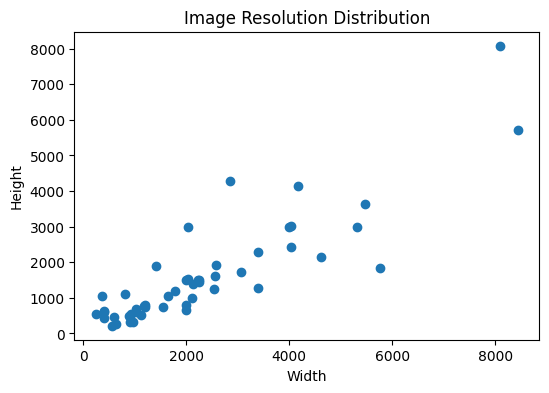

In [19]:
plt.figure(figsize=(6,4))
plt.scatter(img_df["width"], img_df["height"])
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolution Distribution")
plt.show()


## 2.3 Text EDA

In [20]:
# TESTING
import pandas as pd
import time

def scrape_firearm_descriptions(audio_df):
    base_url = "https://guns.fandom.com/wiki/"
    descriptions = []

    for model in audio_df['firearm']:
        # Build URL based on firearm model name
        search_term = model.replace(" ", "_").replace("-", "_")
        url = base_url + search_term

        # Get HTML
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")

        # Get main paragraph text
        paragraphs = soup.find_all("p")
        text = " ".join([p.get_text(strip=True) for p in paragraphs[:2]])  # first 2 paragraphs

        descriptions.append({
            "firearm": model,
            "url": url,
            "description": text
        })
        time.sleep(1)

    return pd.DataFrame(descriptions)
text_df = scrape_firearm_descriptions(audio_df)
display(text_df.head())


KeyboardInterrupt: 

# 3 Preprocessing

## 3.1 Audio Preprocessing

Values for the function need to be aangepast as they dont exactly overlap with the shots fired

In [21]:
from audio_dataset import extract_avg_features
audio_path = "data/audio/original_dataset/"
firearm_features = extract_avg_features(audio_path)
print(firearm_features.head())

KeyboardInterrupt: 

## 3.2 Image Preprocessing

Afbeelding converteren naar RGB

In [22]:
from PIL import Image

def load_and_fix_image(path):
    img = Image.open(path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    return img


Normaliseren van resolutie (resize naar 224×224)
(dat is de standaard formaat voor CNN's)

In [23]:
import numpy as np

TARGET_SIZE = (224, 224)

def resize_image(img):
    return img.resize(TARGET_SIZE)


Normaliseren van pixelwaardes

In [24]:
def normalize(img):
    arr = np.array(img) / 255.0
    return arr


Feature Engenieering

Hier extraheren we low level image features die geschikt zijn voor ML:
bvb:
 - gemiddelde kleur

 - kleurhistogrammen

 - image sharpness

 - aspect ratio

 - luminantie

Feature 1: Aspect Ratio

In [25]:
def aspect_ratio(width, height):
    return width / height


Feature 2: Gemiddelde RGB-waarden

In [26]:
def mean_rgb(img):
    arr = np.array(img)
    return arr.mean(axis=(0,1))


Feature 3: Kleurhistogram (geschaald naar 16 bins per kanaal)

In [27]:
def color_histogram(img):
    arr = np.array(img)
    hist_r = np.histogram(arr[:,:,0], bins=16, range=(0,255))[0]
    hist_g = np.histogram(arr[:,:,1], bins=16, range=(0,255))[0]
    hist_b = np.histogram(arr[:,:,2], bins=16, range=(0,255))[0]
    return np.concatenate([hist_r, hist_g, hist_b])


Feature 4: Sharpness (Laplacian variance)

In [28]:
!pip install opencv-python

import cv2

def image_sharpness(img):
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\rayga\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


checken of alle images werken

In [30]:
import os
from PIL import Image

for path in img_df["path"]:
    print(path, os.path.exists(path))
    try:
        Image.open(path)
        print("   → OK")
    except Exception as e:
        print("   → BAD:", e)


data/images\ak-12.jpg True
   → OK
data/images\ak-47.jpg True
   → OK
data/images\arctic-warfare-magnum.jpg True
   → OK
data/images\beretta-92.jpg True
   → OK
data/images\colt-1911.jpg True
   → OK
data/images\daewoo-k2.jpg True
   → OK
data/images\desert-eagle.jpg True
   → OK
data/images\double-barrel-shotgun.jpg True
   → OK
data/images\dp-27-lmg.jpg True
   → OK
data/images\fn-p90.jpg True
   → OK
data/images\fn-scar.jpg True
   → OK
data/images\glock.jpg True
   → OK
data/images\glock-18c.jpg True
   → OK
data/images\glock-19-9mm-luger-pistol.jpg True
   → OK
data/images\high-standard-22lr.jpg True
   → OK
data/images\hk-g36c.jpg True
   → OK
data/images\hk-ump45.jpg True
   → OK
data/images\kar98k.jpg True
   → OK
data/images\kimber-45acp.jpg True
   → OK
data/images\kriss-vector.jpg True
   → BAD: cannot identify image file 'data/images\\kriss-vector.jpg'
data/images\m16.jpg True
   → OK
data/images\m24-sws.jpg True
   → OK
data/images\m249-lmg.jpg True
   → OK
data/images\m4.

Bouw van de volledige preprocessing + feature pipeline

In [36]:
processed_images = []

for idx, row in img_df.iterrows():
    path = row["path"]

    # skip missing files quickly
    if not os.path.exists(path):
        print(f"Skipping missing file: {path}")
        continue

    # try to open/fix image, skip when unreadable/corrupt
    try:
        img = load_and_fix_image(path)
        if img is None:
            print(f"Skipping unreadable image (None): {path}")
            continue
    except Exception as e:
        print(f"Skipping unreadable image: {path} | {e}")
        continue

    # guard against images that couldn't be opened properly
    try:
        w, h = img.size
    except Exception as e:
        print(f"Skipping image with invalid size: {path} | {e}")
        continue

    # safe mean RGB (handle grayscale images)
    arr = np.array(img)
    if arr.ndim == 2:
        mean_r = mean_g = mean_b = float(arr.mean())
    else:
        m = arr.mean(axis=(0, 1))
        mean_r, mean_g, mean_b = float(m[0]), float(m[1]), float(m[2])

    # safe sharpness (handle grayscale arrays too)
    try:
        if arr.ndim == 2:
            gray = arr
        else:
            # ensure RGB -> gray conversion works
            gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
        sharpness = float(cv2.Laplacian(gray, cv2.CV_64F).var())
    except Exception as e:
        print(f"Sharpness computation failed for {path}: {e}")
        sharpness = np.nan

    # safe color histogram (fallback for grayscale)
    try:
        hist = color_histogram(img)
    except Exception:
        # compute grayscale histogram and duplicate across 3 channels
        ghist = np.histogram(arr if arr.ndim == 2 else cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY),
                             bins=16, range=(0, 255))[0]
        hist = np.concatenate([ghist, ghist, ghist])

    features = {
        "model": row["model"],
        "width": int(w),
        "height": int(h),
        "aspect_ratio": aspect_ratio(w, h) if h not in (0, None) else np.nan,
        "sharpness": sharpness,
        "mean_r": mean_r,
        "mean_g": mean_g,
        "mean_b": mean_b
    }

    # histogram features
    for i in range(len(hist)):
        features[f"hist_{i}"] = int(hist[i])

    processed_images.append(features)

image_features_df = pd.DataFrame(processed_images)
image_features_df.head()

Skipping unreadable image: data/images\kriss-vector.jpg | cannot identify image file 'data/images\\kriss-vector.jpg'
Skipping missing file: data/images\mp-40-40-sw-pistol.jpg


,model,width,height,aspect_ratio,sharpness,mean_r,mean_g,mean_b,hist_0,hist_1,...,hist_38,hist_39,hist_40,hist_41,hist_42,hist_43,hist_44,hist_45,hist_46,hist_47
0,ak-12,2543,1248,2.037660,821.485480,195.229310,194.895628,190.278984,25224,375990,...,30985,14495,19333,5966,2684,3120,2453,3801,1833,2107238
1,ak-47,900,332,2.710843,810.762952,229.192246,224.311523,221.680693,3533,931,...,4646,3687,4142,6972,11983,7219,2099,389,402,228361
2,arctic-warfare-magnum,1998,810,2.466667,326.612217,213.837922,214.163384,215.473786,37513,70163,...,20947,13406,13514,12711,10139,9754,7378,4231,1739,1265845
3,beretta-92,2130,1377,1.546841,180.582781,192.967017,192.566807,191.296599,70267,96786,...,81622,65420,52691,41223,34439,37150,30977,45668,70773,1769254
4,colt-1911,2220,1488,1.491935,131.078160,187.420597,187.420597,187.420597,13,115,...,214292,142265,95596,54276,55029,65398,44269,44643,537011,1383248


Bouw de volledige preprocessing + feature pipeline

Sharpness histogram

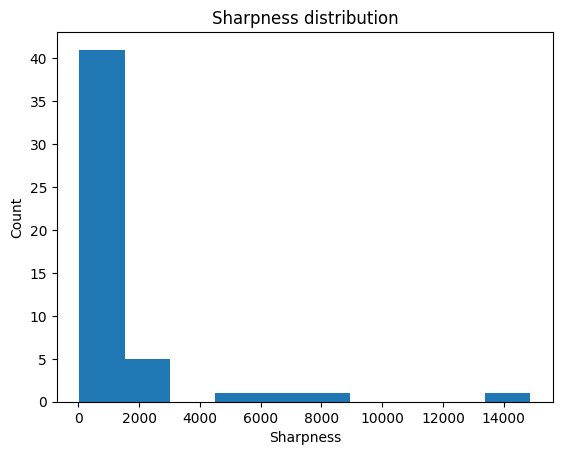

In [37]:
plt.hist(image_features_df["sharpness"], bins=10)
plt.title("Sharpness distribution")
plt.xlabel("Sharpness")
plt.ylabel("Count")
plt.show()


Gemiddelde kleur visualiseren

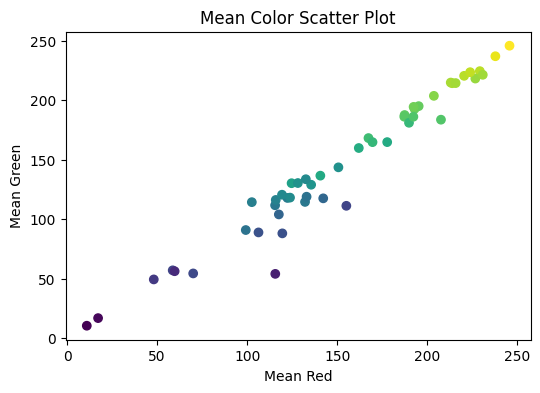

In [38]:
plt.figure(figsize=(6,4))
plt.scatter(image_features_df["mean_r"], image_features_df["mean_g"], c=image_features_df["mean_b"])
plt.xlabel("Mean Red")
plt.ylabel("Mean Green")
plt.title("Mean Color Scatter Plot")
plt.show()


Resultaat + controleren

In [39]:
image_features_df.to_csv("data/images/image_features.csv", index=False)


,model,width,height,aspect_ratio,sharpness,mean_r,mean_g,mean_b,hist_0,hist_1,...,hist_38,hist_39,hist_40,hist_41,hist_42,hist_43,hist_44,hist_45,hist_46,hist_47
0,ak-12,2543,1248,2.037660,821.485480,195.229310,194.895628,190.278984,25224,375990,...,30985,14495,19333,5966,2684,3120,2453,3801,1833,2107238
1,ak-47,900,332,2.710843,810.762952,229.192246,224.311523,221.680693,3533,931,...,4646,3687,4142,6972,11983,7219,2099,389,402,228361
2,arctic-warfare-magnum,1998,810,2.466667,326.612217,213.837922,214.163384,215.473786,37513,70163,...,20947,13406,13514,12711,10139,9754,7378,4231,1739,1265845
3,beretta-92,2130,1377,1.546841,180.582781,192.967017,192.566807,191.296599,70267,96786,...,81622,65420,52691,41223,34439,37150,30977,45668,70773,1769254
4,colt-1911,2220,1488,1.491935,131.078160,187.420597,187.420597,187.420597,13,115,...,214292,142265,95596,54276,55029,65398,44269,44643,537011,1383248


,model,width,height,aspect_ratio,sharpness,mean_r,mean_g,mean_b,hist_0,hist_1,...,hist_38,hist_39,hist_40,hist_41,hist_42,hist_43,hist_44,hist_45,hist_46,hist_47
0,ak-12,2543,1248,2.037660,821.485480,195.229310,194.895628,190.278984,25224,375990,...,30985,14495,19333,5966,2684,3120,2453,3801,1833,2107238
1,ak-47,900,332,2.710843,810.762952,229.192246,224.311523,221.680693,3533,931,...,4646,3687,4142,6972,11983,7219,2099,389,402,228361
2,arctic-warfare-magnum,1998,810,2.466667,326.612217,213.837922,214.163384,215.473786,37513,70163,...,20947,13406,13514,12711,10139,9754,7378,4231,1739,1265845
3,beretta-92,2130,1377,1.546841,180.582781,192.967017,192.566807,191.296599,70267,96786,...,81622,65420,52691,41223,34439,37150,30977,45668,70773,1769254
4,colt-1911,2220,1488,1.491935,131.078160,187.420597,187.420597,187.420597,13,115,...,214292,142265,95596,54276,55029,65398,44269,44643,537011,1383248


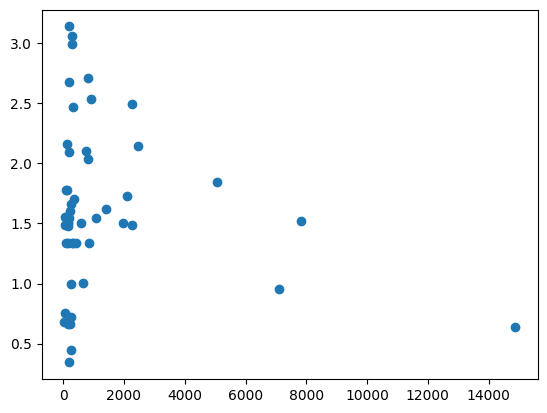

model                ak-12
width                 2543
height                1248
aspect_ratio       2.03766
sharpness        821.48548
mean_r           195.22931
mean_g          194.895628
mean_b          190.278984
hist_0               25224
hist_1              375990
hist_2               42818
hist_3               40748
hist_4              243370
hist_5               17384
hist_6               34984
hist_7               32330
hist_8               57832
hist_9               59852
hist_10              56412
hist_11              60203
hist_12              13686
hist_13               4630
hist_14              24321
hist_15            2083880
hist_16              22149
hist_17             372960
hist_18              29274
hist_19              35079
hist_20              49100
hist_21             263135
hist_22              34426
hist_23              58679
hist_24              64884
hist_25              53755
hist_26              58898
hist_27              12954
hist_28               7115
h

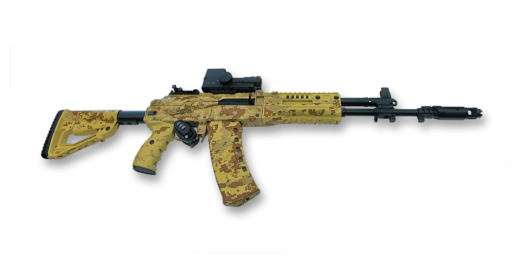

In [46]:
# 1. Dataframe tonen
display(image_features_df.head())

# 2. CSV controleren
display(pd.read_csv("data/images/image_features.csv").head())

# 3. Visualisatie
plt.scatter(image_features_df["sharpness"], image_features_df["aspect_ratio"])
plt.show()

# 4. 1 voorbeeld + features
img = Image.open(img_df["path"].iloc[0])
plt.imshow(img); plt.axis("off")
image_features_df.iloc[0]


## 3.3 Text Preprocessing

In [ ]:
# TESTING
import requests
from bs4 import BeautifulSoup

URL = "https://guns.fandom.com/wiki/Remington_Model_597"
HEADERS = {"User-Agent": "Mozilla/5.0 (compatible; scraping-test/1.0; +mailto:mkakol.index@gmail.com)"}

resp = requests.get(URL, headers=HEADERS, timeout=10)
print("HTTP status:", resp.status_code)
if resp.status_code != 200:
    raise SystemExit("Non-200 response — check status / headers / possible blocking")

soup = BeautifulSoup(resp.content, "lxml")

# Approach: find the heading text "Weapon type" (it's an <h3> or <strong> on some pages)
label = soup.find(lambda tag: tag.name in ("h3","h4","th","strong") and "Weapon type" in tag.get_text())
print("Label found:", bool(label), "tag:", getattr(label, "name", None))
if label:
    # weapon type value is often the next tag (or next sibling)
    # try several sensible moves:
    candidate = label.find_next()
    # find next <a> after label
    weapon_a = label.find_next("a")
    if weapon_a:
        print("Weapon type text:", weapon_a.get_text(strip=True))
        print("Weapon type href:", weapon_a.get("href"))
    else:
        print("No <a> found after label, showing next text:", candidate.get_text(strip=True) if candidate else None)
else:
    # fallback debugging
    snippet = resp.content.decode("utf-8", errors="replace")[:2000]
    print("Could not find 'Weapon type' label. HTML snippet (first 2000 chars):")
    print(snippet)